C:\Users\pullu\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\training.py:183: UserWarning: [23:40:59] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


📊 Model Performance (XGBoost + Behavioral + Personas + Proxies + Composite Indicators):
✅ Accuracy: 0.6206
✅ Precision: 0.2672
✅ Recall: 0.2275
✅ F1 Score: 0.2457
✅ ROC-AUC Score: 0.4974

🔍 Classification Report:
              precision    recall  f1-score   support

           0       0.73      0.77      0.75     14566
           1       0.27      0.23      0.25      5434

    accuracy                           0.62     20000
   macro avg       0.50      0.50      0.50     20000
weighted avg       0.60      0.62      0.61     20000



 92%|==================  | 460/500 [00:11<00:00]       

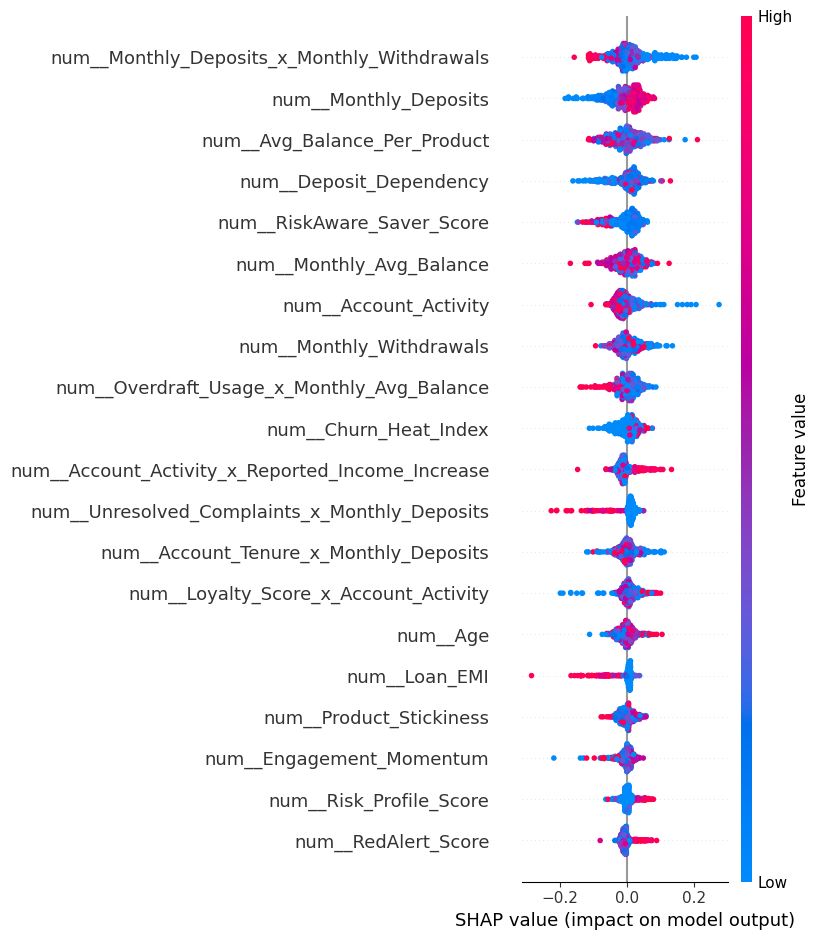

In [2]:
# 📌 Step 1: Import Required Libraries
import pandas as pd
import numpy as np
import xgboost as xgb
import shap
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, classification_report
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
import joblib

# 📌 Step 2: Load Enriched Dataset with Composite Indicators
df = pd.read_csv("../data/features_with_composites.csv")
y = pd.read_csv("../data/hidden_churn_labels.csv")["Churn"]

# 📌 Step 3: Identify Categorical & Numerical Features
categorical_features = ['Gender', 'Income_Group', 'Customer_Type', 'Residency_Status', 'Account_Type', 'Credit_Score']
numerical_features = [col for col in df.columns if col not in categorical_features and col != "Customer_ID"]

# 📌 Step 4: Preprocessing Pipeline
preprocessor = ColumnTransformer([
    ('num', StandardScaler(), numerical_features),
    ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
])

# 📌 Step 5: Train-Test Split
X = df.drop(columns=["Customer_ID"])
X_processed = preprocessor.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X_processed, y, test_size=0.2, stratify=y, random_state=42)

# 📌 Step 6: Train XGBoost Classifier
xgb_model = xgb.XGBClassifier(
    n_estimators=200,
    max_depth=6,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    scale_pos_weight=2.5,  # ⚖️ Adjusted for imbalance
    objective='binary:logistic',
    eval_metric="logloss",
    use_label_encoder=False,
    random_state=42
)

xgb_model.fit(X_train, y_train)

# 📌 Step 7: Save the Trained Model
joblib.dump(xgb_model, "../models/xgb_model_with_composites.pkl")

# 📌 Step 8: Predictions and Performance Evaluation
y_pred = xgb_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred)

# 📊 Model Performance
print(f"📊 Model Performance (XGBoost + Behavioral + Personas + Proxies + Composite Indicators):")
print(f"✅ Accuracy: {accuracy:.4f}")
print(f"✅ Precision: {precision:.4f}")
print(f"✅ Recall: {recall:.4f}")
print(f"✅ F1 Score: {f1:.4f}")
print(f"✅ ROC-AUC Score: {roc_auc:.4f}")
print("\n🔍 Classification Report:")
print(classification_report(y_test, y_pred))

# 📌 Step 9: SHAP Summary Plot
explainer = shap.Explainer(xgb_model, X_train[:500])  # To reduce computation
shap_values = explainer(X_test[:500])

plt.figure(figsize=(10, 6))
shap.summary_plot(shap_values, features=X_test[:500], feature_names=preprocessor.get_feature_names_out())



In [ ]:
we undesrtood what columsn to normalize from plots of segment composite analysis.

In [2]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

# ✅ Load composite-enhanced dataset
df = pd.read_csv("../data/features_with_composites.csv")

# ✅ Identify composites to normalize or clip
composite_cols_to_normalize = [
    'Churn_Heat_Index',
    'RedAlert_Score',
    'Engagement_Drop_Score',
    'Confidence_Drop_Score',
    'Stickiness_Score',
    'Exit_Intent_Score',
    'Risk_Profile_Score'
]

# ✅ Clip extreme values if needed (e.g., Churn_Heat_Index)
# Optional: only for columns with exploding values
for col in ['Churn_Heat_Index']:
    df[col] = df[col].clip(upper=df[col].quantile(0.99))  # top 1% clipping

# ✅ Normalize (0 to 1 scale)
scaler = MinMaxScaler()
df[composite_cols_to_normalize] = scaler.fit_transform(df[composite_cols_to_normalize])

# ✅ Save normalized version
df.to_csv("../data/features_with_composites_normalized.csv", index=False)
print("✅ Saved: features_with_composites_normalized.csv with normalized composite indicators.")


✅ Saved: features_with_composites_normalized.csv with normalized composite indicators.


In [ ]:
#and continuing this csv file to new xgboost model including every other feature.

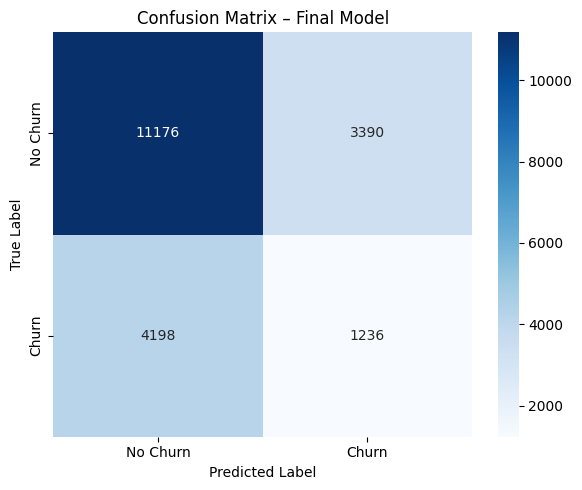

In [4]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# 📌 Compute Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
labels = ["No Churn", "Churn"]
cm_display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)

# 📊 Enhanced Plot with Seaborn
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix – Final Model")
plt.tight_layout()
plt.show()


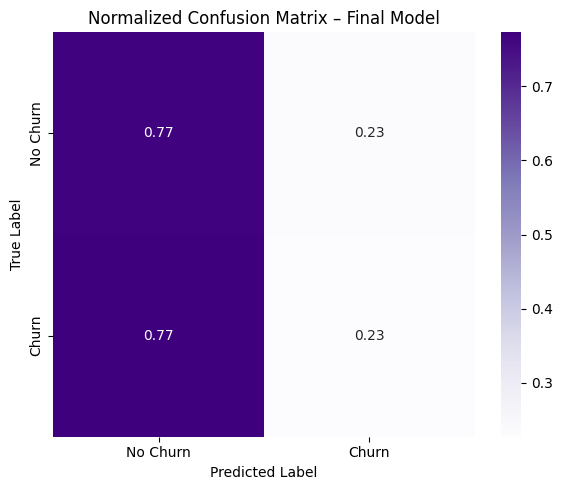

In [6]:
# Normalize the confusion matrix
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(6, 5))
sns.heatmap(cm_normalized, annot=True, fmt='.2f', cmap='Purples', xticklabels=labels, yticklabels=labels)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Normalized Confusion Matrix – Final Model")
plt.tight_layout()
plt.show()
